In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt 
import seaborn as sns

https://www.atlantafed.org/cqer/research/taylor-rule#Tab1

# Tayor Rule

$r = R_{n} + \pi + 0.5(\pi - \pi^*) + 0.5(y - y^*) $

$r$: Central Bank policy rate implied by the Taylor Rule \
$R_{n}$: neutral real policy interest rate \
$\pi$: current inflation rate \
$\pi^*$: Central Bank's target inflation rate \
$y$: log(current level of output) \
$y^*$: log(Central Bank's target(sustainable) output)

In [3]:
variables = {
'CPIAUCSL':'CPI', 
'GDPC1': 'real_GDP',
'GDPPOT': 'potential_GDP', 
'FEDFUNDS': 'Fed_funds_rate', 
'CPIAUCSL': 'CPI'
}

data = web.DataReader(variables.keys(), 'fred', '18540101', '20230914')
data = data.rename(columns=variables)
# Economic Data -> low frequency, Quarterly data forward filled monthly with latest Quarter release data
data = data.fillna(method='ffill')
# drop very old period lacking data availability
data = data.dropna( how='any')
data = data.assign( GDP_gap = np.log(data['real_GDP'] / data['potential_GDP']) * 100,
                    CPI_YoY = data['CPI'].pct_change(12) * 100
                  )
data = data.dropna( how='any')

In [4]:
# Taylor Rule formula
def taylor_rule(R_n, pi, pi_star, y, y_star):
    GDP_gap = np.log(y) - np.log(y_star)
    r = R_n + pi + 0.5 * (pi - pi_star) + 0.5 * GDP_gap
    #i = inflation + 0.5 * GDP_gap + 0.5 * (inflation - 2) + 2
    return r

In [5]:
### current economic condition
pi = data.CPI_YoY
y = data.real_GDP

### subject to estimations
# Fed's Target Inflation rate
pi_star = 2
# Neutral interest rate (long-run interest rate target) adds spread on the long run inflation target
R_n = pi_star + 0.5
y_star = data.potential_GDP

# taylor rule rate rounded to 2dp to match federal funds rate format
data['taylor_rule'] = taylor_rule(R_n, pi, pi_star, y, y_star).round(2)

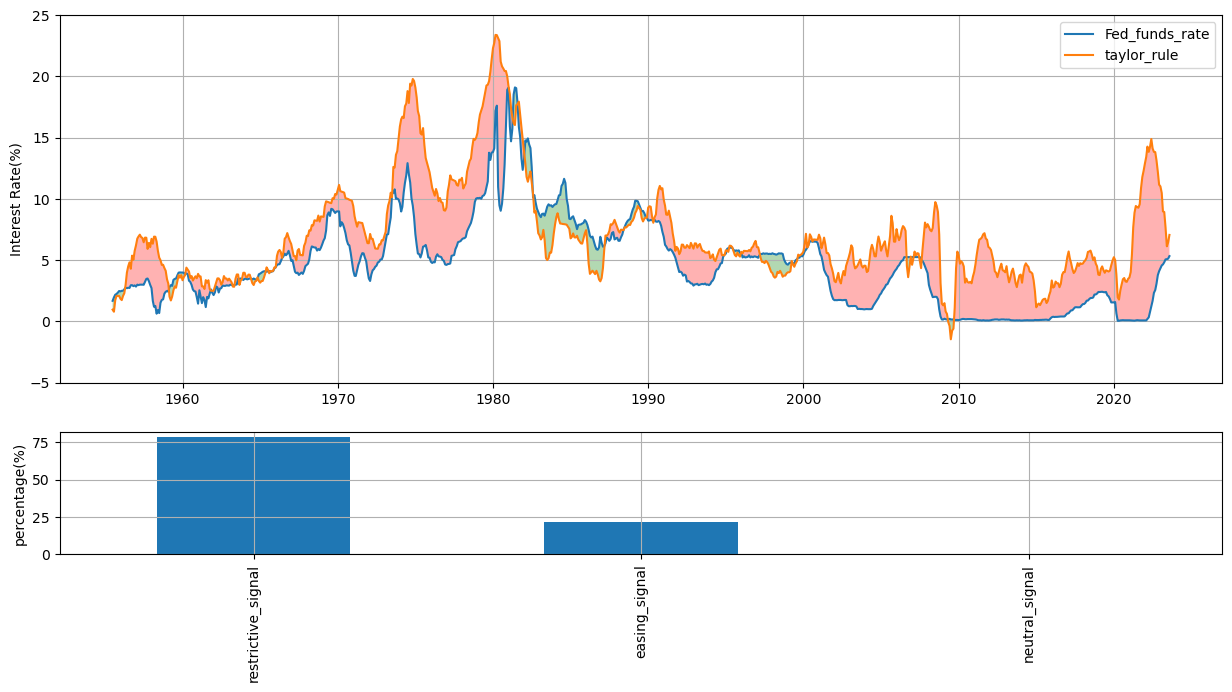

In [6]:
fig, ax = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(15,7))
ax[0].plot(data[['Fed_funds_rate', 'taylor_rule']], label = ['Fed_funds_rate', 'taylor_rule']);
ax[0].grid()
ax[0].set_ylabel('Interest Rate(%)')
ax[0].set_ylim(bottom=-5, top=25)
ax[0].fill_between(x=data.index, y1=data.Fed_funds_rate, y2=data.taylor_rule, 
                where=(data.Fed_funds_rate < data.taylor_rule), facecolor='r', alpha=0.3)
ax[0].fill_between(x=data.index, y1=data.Fed_funds_rate, y2=data.taylor_rule, 
                where=(data.Fed_funds_rate > data.taylor_rule), facecolor='g', alpha=0.3)
ax[0].legend();

# Policy rate < Taylor rule rate: call for more restrictive policy rate
# Policy rate > Taylor rule rate: call for more easing policy rate
# Policy rate == Taylor rule rate: neutral policy rate
condlist = [data.Fed_funds_rate < data.taylor_rule, data.Fed_funds_rate > data.taylor_rule]
choicelist = ['restrictive_signal', 'easing_signal']
policy_signals = np.select(condlist, choicelist, default='neutral')
policy_signals = pd.DataFrame(policy_signals, index=data.index, columns=['policy_signal'])
policy_signals = (policy_signals.value_counts() / len(policy_signals) * 100).set_axis(['restrictive_signal', 'easing_signal', 'neutral_signal'], axis=0)
policy_signals.plot(kind='bar', ax=ax[1]);
plt.ylabel('percentage(%)')
plt.grid();